In [29]:
import numpy as np
from scipy import signal, io
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = 10, 5

# Basic Filt-Filt operation definition

- FeedBack filter components `[M]`:   $A = a_0, a_1, a_2 \dots a_M$, where $a_0 = 0$ by definition
- FeedForward filter components`[N]`:   $B = b_0, b_1, b_2 \dots b_N$

```
y(t) = x(t)*b(0) + x(t-1)*b(1) + x(t-2)*b(2) ... x(t-M)*b(N)
                 - y(t-1)*a(1) - y(t-2)*a(2) ... y(t-N)*a(M)
```

$$
y_t = \sum_{i=0}^{N} x_{t-i} \cdot b_{i} - \sum_{i=1}^{M} y_{t-i} \cdot a_{i}
$$


```
y(t) = x[t-N : t] * b[::-1] - y[t-M : t-1] * a[:0:-1]
```

In [2]:
def dumb_filt(b, a, x, pad=True):
    N = len(b)
    M = len(a)
    edge = max(N, M)
    
    if pad: x_padded = np.pad(x, edge, mode='constant')
    else: x_padded = x
    y = np.zeros(edge)
    
    for t in range(edge, len(x_padded)):
        y = np.append(y, np.dot(x_padded[t-N:t], b) - np.dot(y[-M:], a))
    if pad: return y[edge:-edge]
    else: return y

In [3]:
def dumb_filtfilt(b, a, x, pad=True):
    _b = b[::-1] / a[0]
    _a = a[:0:-1] / a[0]
    y = dumb_filt(_b, _a, x, pad)
    y = dumb_filt(_b, _a, y[::-1], pad)
    return y[::-1]

## Transposed Direct From II (TDF-II)
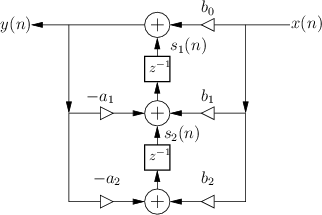
source: https://www.dsprelated.com/freebooks/filters/Transposed_Direct_Forms.html

NUMERICAL ROBUSTNESS OF TDF-II: An advantage of the transposed direct-form II structure (depicted in Figure) is that the zeros effectively precede the poles in series order. As mentioned above, in many digital filters design, the poles by themselves give a large gain at some frequencies, and the zeros often provide compensating attenuation. This is especially true of filters with sharp transitions in their frequency response, such as the elliptic-function-filter; in such filters, the sharp transitions are achieved using near pole-zero cancellations close to the unit circle in the $ z$ plane.

In [4]:
def filt(b, a, x, z, pad=True):
    a[0] = 0
    N = len(b)
    M = len(a)
    edge = max(N, M)
    
    if pad: x_padded = np.pad(x, edge, mode='constant')
    else: x_padded = x
    y = np.array([])
    z = np.append(z, 0)
    
    for t in range(len(x_padded)):
        y = np.append(y, b[0] * x_padded[t] + z[0])
        for i in range(1,M):
            z[i-1] = b[i] * x_padded[t] + z[i] - a[i] * y[t]
            
    z = z[:M-1]
    if pad: return y[edge:-edge]
    else: return y

In [5]:
def filtfilt(b, a, x, pad=True):
    z = signal.lfilter_zi(b, a)
    _b = b / a[0]
    _a = a / a[0]
    y = filt(_b, _a, x, z * x[0], pad)
    y = filt(_b, _a, y[::-1], z* y[-1], pad)
    return y[::-1]

## Testing with real ECG signal and bandpass filter

In [10]:
#convenience functions
fs = rate = 300.
nyq = 0.5 * fs
low = 5 / nyq
high = 15 / nyq
window_size = 300
order = 4
b,a = signal.butter(order, [low, high], 'band')

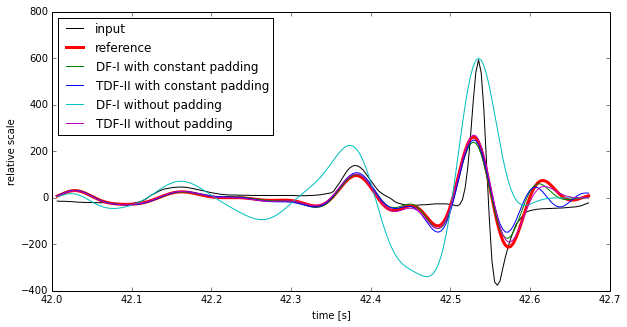

In [37]:
data = io.loadmat("training_set/A06014.mat")['val'][0]
y1 = signal.filtfilt(b, a, data)
y2 = filtfilt(b, a, data)
y3 = dumb_filtfilt(b, a, data)
y2_wp = filtfilt(b, a, data, False)
y3_wp = dumb_filtfilt(b, a, data, False)

start = -200
end = -1
t = np.linspace((len(data)+start)/fs,len(data)/fs,num=abs(start)-1)
plt.plot(t,data[start:end], 'k-', label='input')
plt.plot(t,y1[start:end], 'r-', linewidth=3, label='reference')
plt.plot(t,y3[start:end], 'g-', label='DF-I with constant padding')
plt.plot(t,y2[start:end], 'b-', label='TDF-II with constant padding')
plt.plot(t,y3_wp[start:end], 'c-', label='DF-I without padding')
plt.plot(t,y2_wp[start:end], 'm-',label='TDF-II without padding')
plt.legend(loc='best')
plt.xlabel('time [s]')
plt.ylabel('relative scale')
plt.show()

## A crazy idea to measure the effect of changing the padding around the signal

In [326]:
result = []
start = 20
for num in range(start, 40):
    data = io.loadmat("training_set/A067%02d.mat" % num)['val'][0]
    result.append([])

    y1 = signal.filtfilt(b, a, data)
    for i in range(0,10):
        y2 = filtfilt(b, a, data, i**2)
        result[num-start].append(np.sum((y1-y2)**2))
    print(num)
print(np.argmin(np.sum(result, axis=1)))

20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
10


"\nstart = 0\nend = 1000\nplt.plot(data[start:end], 'k-', label='input')\nplt.plot(y2[start:end], 'b-', linewidth=1.5, label='manual')\nplt.plot(y1[start:end], 'g-', linewidth=1.5, label='builtin')\nplt.legend(loc='best')\nplt.show()\n"

Though it might be slightly better at longer paddings, it does not worth to use a padding more than two times longer than the filters

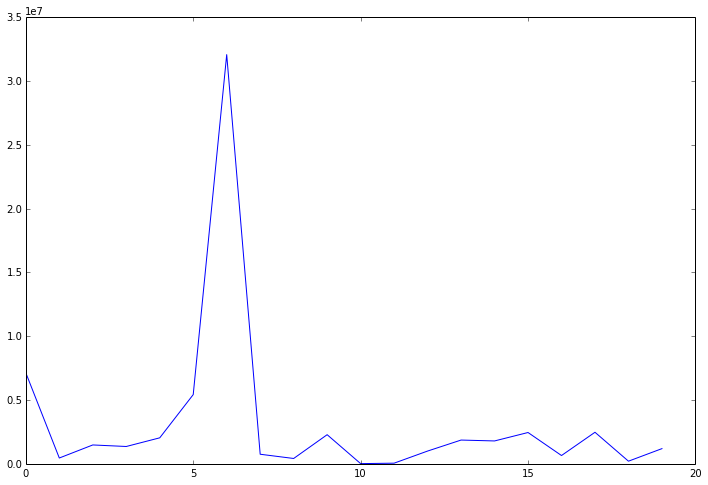

In [328]:
plt.plot(np.sum(result, axis=1))
plt.show()

## Display difference compared to reference (signal.filtfilt's output)

83.0316283149 69.4102271391 88.1768466759 -435.023312976


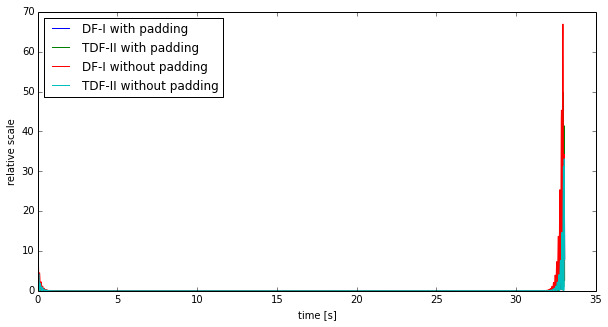

In [33]:
print(np.sum(y1-y2),np.sum(y1-y3), np.sum(y1-y2_wp), np.sum(y1-y3_wp))
#plt.plot(data, 'k-', label='input')
t = np.linspace(0,len(data)/fs,num=len(data))
plt.plot(t,abs(y1-y3), label='DF-I with padding')
plt.plot(t,abs(y1-y2), label='TDF-II with padding')
plt.plot(t,abs(y1-y3_wp), label='DF-I without padding')
plt.plot(t,abs(y1-y2_wp), label='TDF-II without padding')
plt.legend(loc='best')
plt.xlabel('time [s]')
plt.ylabel('relative scale')
plt.show()
# 75 > kis külöbség
# 99 > nagy különbség

## Measure accuracy of filtering functions compared to signal.filtfilt

In [48]:
start = 500
end = 1000
result = []
for i in range(start, end):
    data = io.loadmat("training_set/A04%03d.mat" % i)['val'][0]
    result.append([])

    y1 = signal.filtfilt(b, a, data)
    y2 = filtfilt(b, a, data)
    y3 = dumb_filtfilt(b, a, data)
    y4 = filtfilt(b, a, data, False)
    y5 = dumb_filtfilt(b, a, data, False)
    result[-1].append(np.sum((y1-y2)**2))
    result[-1].append(np.sum((y1-y3)**2))
    result[-1].append(np.sum((y1-y4)**2))
    result[-1].append(np.sum((y1-y5)**2))
    
    print("Progress {:2.1%}".format((i-start) / (end-start)), end="\r")
print("Finished          ")


Finished          


[ 0.11606626  1.          0.14042889  0.        ]


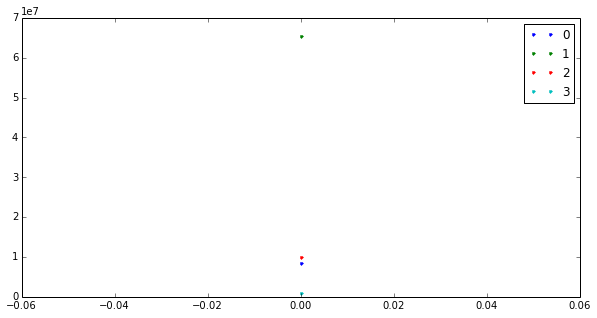

In [49]:
summary = [np.sum(result[:][i]) for i in range(4)]
print((summary-np.min(summary))/np.max(summary-np.min(summary)))
'''
4000-4500:[ 0.11606626  1.          0.14042889  0.        ]
5000-es:[ 0.00195394  0.03990731  1.          0.00985413]
5000-5500:[ 0.          0.03802768  1.          0.00791566]
5500-6000:[  8.14086233e-05   0.00000000e+00   5.64260536e-02   1.00000000e+00]
6000-es:[ 1.          0.          0.83565184  0.07604584]
'''

for i in range(4):
    plt.plot(np.array(summary[:][i]), '.', label='%d' % i)
plt.legend(loc='best')
plt.show()

# Code of signal.filtfilt
 - https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html
 - http://github.com/scipy/scipy/blob/v0.19.0/scipy/signal/signaltools.py
 - https://github.com/scipy/scipy/tree/master/scipy/signal

In [578]:
def axis_slice(a, start=None, stop=None, step=None, axis=-1):
    """Take a slice along axis 'axis' from 'a'.
    Parameters
    ----------
    a : numpy.ndarray
        The array to be sliced.
    start, stop, step : int or None
        The slice parameters.
    axis : int, optional
        The axis of `a` to be sliced.
    Examples
    --------
    >>> a = array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
    >>> axis_slice(a, start=0, stop=1, axis=1)
    array([[1],
           [4],
           [7]])
    >>> axis_slice(a, start=1, axis=0)
    array([[4, 5, 6],
           [7, 8, 9]])
    Notes
    -----
    The keyword arguments start, stop and step are used by calling
    slice(start, stop, step).  This implies axis_slice() does not
    handle its arguments the exacty the same as indexing.  To select
    a single index k, for example, use
        axis_slice(a, start=k, stop=k+1)
    In this case, the length of the axis 'axis' in the result will
    be 1; the trivial dimension is not removed. (Use numpy.squeeze()
    to remove trivial axes.)
    """
    a_slice = [slice(None)] * a.ndim
    a_slice[axis] = slice(start, stop, step)
    b = a[a_slice]
    return b


def axis_reverse(a, axis=-1):
    """Reverse the 1-d slices of `a` along axis `axis`.
    Returns axis_slice(a, step=-1, axis=axis).
    """
    return axis_slice(a, step=-1, axis=axis)


def odd_ext(x, n, axis=-1):
    """
    Odd extension at the boundaries of an array
    Generate a new ndarray by making an odd extension of `x` along an axis.
    Parameters
    ----------
    x : ndarray
        The array to be extended.
    n : int
        The number of elements by which to extend `x` at each end of the axis.
    axis : int, optional
        The axis along which to extend `x`.  Default is -1.
    Examples
    --------
    >>> from scipy.signal._arraytools import odd_ext
    >>> a = np.array([[1, 2, 3, 4, 5], [0, 1, 4, 9, 16]])
    >>> odd_ext(a, 2)
    array([[-1,  0,  1,  2,  3,  4,  5,  6,  7],
           [-4, -1,  0,  1,  4,  9, 16, 23, 28]])
    Odd extension is a "180 degree rotation" at the endpoints of the original
    array:
    >>> t = np.linspace(0, 1.5, 100)
    >>> a = 0.9 * np.sin(2 * np.pi * t**2)
    >>> b = odd_ext(a, 40)
    >>> import matplotlib.pyplot as plt
    >>> plt.plot(arange(-40, 140), b, 'b', lw=1, label='odd extension')
    >>> plt.plot(arange(100), a, 'r', lw=2, label='original')
    >>> plt.legend(loc='best')
    >>> plt.show()
    """
    if n < 1:
        return x
    if n > x.shape[axis] - 1:
        raise ValueError(("The extension length n (%d) is too big. " +
                         "It must not exceed x.shape[axis]-1, which is %d.")
                         % (n, x.shape[axis] - 1))
    left_end = axis_slice(x, start=0, stop=1, axis=axis)
    left_ext = axis_slice(x, start=n, stop=0, step=-1, axis=axis)
    right_end = axis_slice(x, start=-1, axis=axis)
    right_ext = axis_slice(x, start=-2, stop=-(n + 2), step=-1, axis=axis)
    ext = np.concatenate((2 * left_end - left_ext,
                          x,
                          2 * right_end - right_ext),
                         axis=axis)
    return ext


def even_ext(x, n, axis=-1):
    """
    Even extension at the boundaries of an array
    Generate a new ndarray by making an even extension of `x` along an axis.
    Parameters
    ----------
    x : ndarray
        The array to be extended.
    n : int
        The number of elements by which to extend `x` at each end of the axis.
    axis : int, optional
        The axis along which to extend `x`.  Default is -1.
    Examples
    --------
    >>> from scipy.signal._arraytools import even_ext
    >>> a = np.array([[1, 2, 3, 4, 5], [0, 1, 4, 9, 16]])
    >>> even_ext(a, 2)
    array([[ 3,  2,  1,  2,  3,  4,  5,  4,  3],
           [ 4,  1,  0,  1,  4,  9, 16,  9,  4]])
    Even extension is a "mirror image" at the boundaries of the original array:
    >>> t = np.linspace(0, 1.5, 100)
    >>> a = 0.9 * np.sin(2 * np.pi * t**2)
    >>> b = even_ext(a, 40)
    >>> import matplotlib.pyplot as plt
    >>> plt.plot(arange(-40, 140), b, 'b', lw=1, label='even extension')
    >>> plt.plot(arange(100), a, 'r', lw=2, label='original')
    >>> plt.legend(loc='best')
    >>> plt.show()
    """
    if n < 1:
        return x
    if n > x.shape[axis] - 1:
        raise ValueError(("The extension length n (%d) is too big. " +
                         "It must not exceed x.shape[axis]-1, which is %d.")
                         % (n, x.shape[axis] - 1))
    left_ext = axis_slice(x, start=n, stop=0, step=-1, axis=axis)
    right_ext = axis_slice(x, start=-2, stop=-(n + 2), step=-1, axis=axis)
    ext = np.concatenate((left_ext,
                          x,
                          right_ext),
                         axis=axis)
    return ext


def const_ext(x, n, axis=-1):
    """
    Constant extension at the boundaries of an array
    Generate a new ndarray that is a constant extension of `x` along an axis.
    The extension repeats the values at the first and last element of
    the axis.
    Parameters
    ----------
    x : ndarray
        The array to be extended.
    n : int
        The number of elements by which to extend `x` at each end of the axis.
    axis : int, optional
        The axis along which to extend `x`.  Default is -1.
    Examples
    --------
    >>> from scipy.signal._arraytools import const_ext
    >>> a = np.array([[1, 2, 3, 4, 5], [0, 1, 4, 9, 16]])
    >>> const_ext(a, 2)
    array([[ 1,  1,  1,  2,  3,  4,  5,  5,  5],
           [ 0,  0,  0,  1,  4,  9, 16, 16, 16]])
    Constant extension continues with the same values as the endpoints of the
    array:
    >>> t = np.linspace(0, 1.5, 100)
    >>> a = 0.9 * np.sin(2 * np.pi * t**2)
    >>> b = const_ext(a, 40)
    >>> import matplotlib.pyplot as plt
    >>> plt.plot(arange(-40, 140), b, 'b', lw=1, label='constant extension')
    >>> plt.plot(arange(100), a, 'r', lw=2, label='original')
    >>> plt.legend(loc='best')
    >>> plt.show()
    """
    if n < 1:
        return x
    left_end = axis_slice(x, start=0, stop=1, axis=axis)
    ones_shape = [1] * x.ndim
    ones_shape[axis] = n
    ones = np.ones(ones_shape, dtype=x.dtype)
    left_ext = ones * left_end
    right_end = axis_slice(x, start=-1, axis=axis)
    right_ext = ones * right_end
    ext = np.concatenate((left_ext,
                          x,
                          right_ext),
                         axis=axis)
    return ext


def zero_ext(x, n, axis=-1):
    """
    Zero padding at the boundaries of an array
    Generate a new ndarray that is a zero padded extension of `x` along
    an axis.
    Parameters
    ----------
    x : ndarray
        The array to be extended.
    n : int
        The number of elements by which to extend `x` at each end of the
        axis.
    axis : int, optional
        The axis along which to extend `x`.  Default is -1.
    Examples
    --------
    >>> from scipy.signal._arraytools import zero_ext
    >>> a = np.array([[1, 2, 3, 4, 5], [0, 1, 4, 9, 16]])
    >>> zero_ext(a, 2)
    array([[ 0,  0,  1,  2,  3,  4,  5,  0,  0],
           [ 0,  0,  0,  1,  4,  9, 16,  0,  0]])
    """
    if n < 1:
        return x
    zeros_shape = list(x.shape)
    zeros_shape[axis] = n
    zeros = np.zeros(zeros_shape, dtype=x.dtype)
    ext = np.concatenate((zeros, x, zeros), axis=axis)
    return ext

In [579]:
def _validate_pad(padtype, padlen, x, axis, ntaps):
    """Helper to validate padding for filtfilt"""
    if padtype not in ['even', 'odd', 'constant', None]:
        raise ValueError(("Unknown value '%s' given to padtype.  padtype "
                          "must be 'even', 'odd', 'constant', or None.") %
                         padtype)

    if padtype is None:
        padlen = 0

    if padlen is None:
        # Original padding; preserved for backwards compatibility.
        edge = ntaps * 3
    else:
        edge = padlen

    # x's 'axis' dimension must be bigger than edge.
    if x.shape[axis] <= edge:
        raise ValueError("The length of the input vector x must be at least "
                         "padlen, which is %d." % edge)

    if padtype is not None and edge > 0:
        # Make an extension of length `edge` at each
        # end of the input array.
        if padtype == 'even':
            ext = even_ext(x, edge, axis=axis)
        elif padtype == 'odd':
            ext = odd_ext(x, edge, axis=axis)
        else:
            ext = const_ext(x, edge, axis=axis)
    else:
        ext = x
    return edge, ext

In [580]:
def builtin_filtfilt(b, a, x, axis=-1, padtype='odd', padlen=None, method='pad',irlen=None):
    """
    A forward-backward filter.
    This function applies a linear filter twice, once forward and once
    backwards.  The combined filter has linear phase.
    The function provides options for handling the edges of the signal.
    When `method` is "pad", the function pads the data along the given axis
    in one of three ways: odd, even or constant.  The odd and even extensions
    have the corresponding symmetry about the end point of the data.  The
    constant extension extends the data with the values at the end points. On
    both the forward and backward passes, the initial condition of the
    filter is found by using `lfilter_zi` and scaling it by the end point of
    the extended data.
    When `method` is "gust", Gustafsson's method [1]_ is used.  Initial
    conditions are chosen for the forward and backward passes so that the
    forward-backward filter gives the same result as the backward-forward
    filter.
    Parameters
    ----------
    b : (N,) array_like
        The numerator coefficient vector of the filter.
    a : (N,) array_like
        The denominator coefficient vector of the filter.  If ``a[0]``
        is not 1, then both `a` and `b` are normalized by ``a[0]``.
    x : array_like
        The array of data to be filtered.
    axis : int, optional
        The axis of `x` to which the filter is applied.
        Default is -1.
    padtype : str or None, optional
        Must be 'odd', 'even', 'constant', or None.  This determines the
        type of extension to use for the padded signal to which the filter
        is applied.  If `padtype` is None, no padding is used.  The default
        is 'odd'.
    padlen : int or None, optional
        The number of elements by which to extend `x` at both ends of
        `axis` before applying the filter.  This value must be less than
        ``x.shape[axis] - 1``.  ``padlen=0`` implies no padding.
        The default value is ``3 * max(len(a), len(b))``.
    method : str, optional
        Determines the method for handling the edges of the signal, either
        "pad" or "gust".  When `method` is "pad", the signal is padded; the
        type of padding is determined by `padtype` and `padlen`, and `irlen`
        is ignored.  When `method` is "gust", Gustafsson's method is used,
        and `padtype` and `padlen` are ignored.
    irlen : int or None, optional
        When `method` is "gust", `irlen` specifies the length of the
        impulse response of the filter.  If `irlen` is None, no part
        of the impulse response is ignored.  For a long signal, specifying
        `irlen` can significantly improve the performance of the filter.
    Returns
    -------
    y : ndarray
        The filtered output with the same shape as `x`.
    See Also
    --------
    sosfiltfilt, lfilter_zi, lfilter, lfiltic, savgol_filter, sosfilt
    Notes
    -----
    The option to use Gustaffson's method was added in scipy version 0.16.0.
    References
    ----------
    .. [1] F. Gustaffson, "Determining the initial states in forward-backward
           filtering", Transactions on Signal Processing, Vol. 46, pp. 988-992,
           1996.
    Examples
    --------
    The examples will use several functions from `scipy.signal`.
    >>> from scipy import signal
    >>> import matplotlib.pyplot as plt
    First we create a one second signal that is the sum of two pure sine
    waves, with frequencies 5 Hz and 250 Hz, sampled at 2000 Hz.
    >>> t = np.linspace(0, 1.0, 2001)
    >>> xlow = np.sin(2 * np.pi * 5 * t)
    >>> xhigh = np.sin(2 * np.pi * 250 * t)
    >>> x = xlow + xhigh
    Now create a lowpass Butterworth filter with a cutoff of 0.125 times
    the Nyquist rate, or 125 Hz, and apply it to ``x`` with `filtfilt`.
    The result should be approximately ``xlow``, with no phase shift.
    >>> b, a = signal.butter(8, 0.125)
    >>> y = signal.filtfilt(b, a, x, padlen=150)
    >>> np.abs(y - xlow).max()
    9.1086182074789912e-06
    We get a fairly clean result for this artificial example because
    the odd extension is exact, and with the moderately long padding,
    the filter's transients have dissipated by the time the actual data
    is reached.  In general, transient effects at the edges are
    unavoidable.
    The following example demonstrates the option ``method="gust"``.
    First, create a filter.
    >>> b, a = signal.ellip(4, 0.01, 120, 0.125)  # Filter to be applied.
    >>> np.random.seed(123456)
    `sig` is a random input signal to be filtered.
    >>> n = 60
    >>> sig = np.random.randn(n)**3 + 3*np.random.randn(n).cumsum()
    Apply `filtfilt` to `sig`, once using the Gustafsson method, and
    once using padding, and plot the results for comparison.
    >>> fgust = signal.filtfilt(b, a, sig, method="gust")
    >>> fpad = signal.filtfilt(b, a, sig, padlen=50)
    >>> plt.plot(sig, 'k-', label='input')
    >>> plt.plot(fgust, 'b-', linewidth=4, label='gust')
    >>> plt.plot(fpad, 'c-', linewidth=1.5, label='pad')
    >>> plt.legend(loc='best')
    >>> plt.show()
    The `irlen` argument can be used to improve the performance
    of Gustafsson's method.
    Estimate the impulse response length of the filter.
    >>> z, p, k = signal.tf2zpk(b, a)
    >>> eps = 1e-9
    >>> r = np.max(np.abs(p))
    >>> approx_impulse_len = int(np.ceil(np.log(eps) / np.log(r)))
    >>> approx_impulse_len
    137
    Apply the filter to a longer signal, with and without the `irlen`
    argument.  The difference between `y1` and `y2` is small.  For long
    signals, using `irlen` gives a significant performance improvement.
    >>> x = np.random.randn(5000)
    >>> y1 = signal.filtfilt(b, a, x, method='gust')
    >>> y2 = signal.filtfilt(b, a, x, method='gust', irlen=approx_impulse_len)
    >>> print(np.max(np.abs(y1 - y2)))
    1.80056858312e-10
    """
    b = np.atleast_1d(b)
    a = np.atleast_1d(a)
    x = np.asarray(x)

    if method not in ["pad", "gust"]:
        raise ValueError("method must be 'pad' or 'gust'.")

    if method == "gust":
        y, z1, z2 = _filtfilt_gust(b, a, x, axis=axis, irlen=irlen)
        return y

    # method == "pad"
    edge, ext = _validate_pad(padtype, padlen, x, axis,
                              ntaps=max(len(a), len(b)))

    # Get the steady state of the filter's step response.
    zi = lfilter_zi(b, a)

    # Reshape zi and create x0 so that zi*x0 broadcasts
    # to the correct value for the 'zi' keyword argument
    # to lfilter.
    zi_shape = [1] * x.ndim
    zi_shape[axis] = zi.size
    zi = np.reshape(zi, zi_shape)
    x0 = axis_slice(ext, stop=1, axis=axis)

    # Forward filter.
    (y, zf) = lfilter(b, a, ext, axis=axis, zi=zi * x0)

    # Backward filter.
    # Create y0 so zi*y0 broadcasts appropriately.
    y0 = axis_slice(y, start=-1, axis=axis)
    (y, zf) = lfilter(b, a, axis_reverse(y, axis=axis), axis=axis, zi=zi * y0)

    # Reverse y.
    y = axis_reverse(y, axis=axis)

    if edge > 0:
        # Slice the actual signal from the extended signal.
        y = axis_slice(y, start=edge, stop=-edge, axis=axis)

    return y

## "Why is my code not working as intended?"-section

In [754]:
def smart_filtfilt(b, a, x, axis=-1, padtype='odd', padlen=None, method='pad',irlen=None):
    edge, ext = _validate_pad(padtype, padlen, x, axis, ntaps=max(len(a), len(b)))
    zi = signal.lfilter_zi(b, a)
    _b = b / a[0]
    _a = a / a[0]
    x_padded = odd_ext(x, edge)
    y2, zf = signal.lfilter(b, a, ext, axis, zi)
    y = filt(_b, _a, x_padded, z=zi * x_padded[0], pad=False)
    _a = _a[:0:-1]
    y3 = dumb_filt(_b, _a, x_padded, pad=False)
    plt.plot(y[0:300], label='my')
    plt.plot(y3[1:300], label='dumb')
    plt.plot(y2[0:300], label='builtin')
    plt.legend()
    plt.show()
    #for i in range(min(len(y), len(y2))):
        #print(y[i],y2[i])
    #y = filt(_b, _a, axis_reverse(y, axis=axis), z=zi * y[-1])
    #y = axis_reverse(y, axis=axis)
    #y = axis_slice(y, start=edge, stop=-edge, axis=axis)
    return y

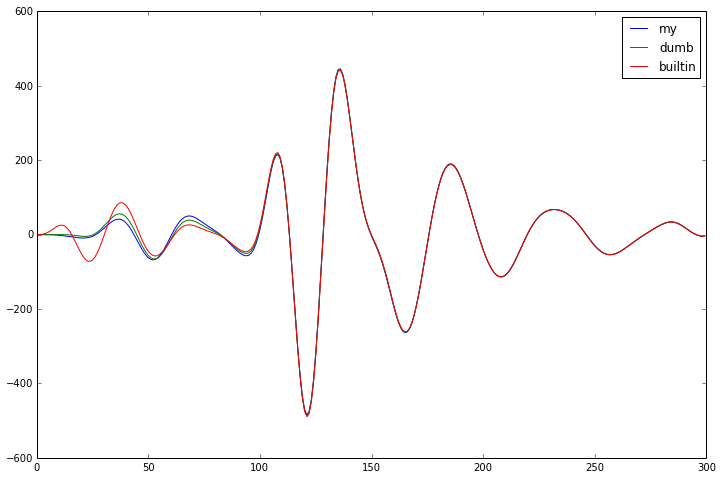

array([ -3.11617548e-10,  -4.63823413e-04,  -4.23492427e-03, ...,
        -9.47127287e+00,  -2.02763768e+01,  -3.81240068e+01])

In [755]:
smart_filtfilt(b, a, data)
#print(np.sum(smart_filtfilt(b, a, data)[:9840]- signal.filtfilt(b, a, data)))

In [584]:
edge, ext = _validate_pad(padtype='odd', padlen=None, x=data, axis=-1,
                              ntaps=max(len(a), len(b)))
print(len(ext), len(data), edge)

9894 9840 27


## Playing with Pan-Tompkins filtering

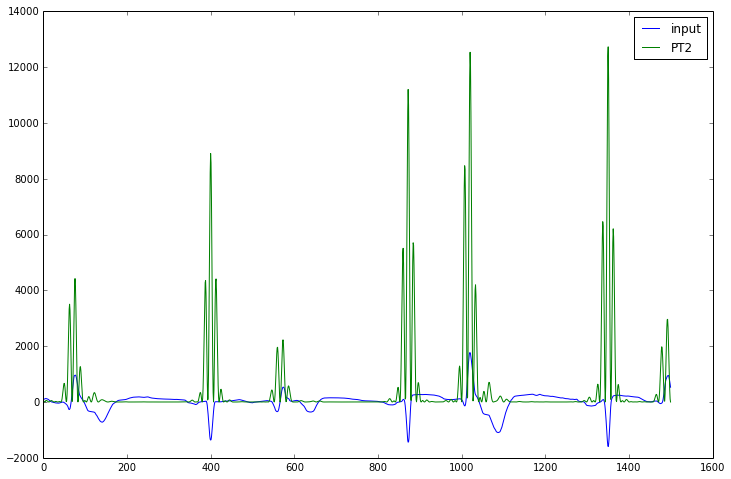

In [759]:
data = io.loadmat("training_set/A06799.mat")['val'][0]
b,a = signal.butter(order, [low, high], 'band')
y_bandpass = dumb_filtfilt(b, a, data)

y_diff1 = np.diff(y_bandpass)
y_power1 = y_diff1**2

b_DEV = np.array([1. / 3.6, 0, 1. / 8, 0, -1. / 8, 0, -1. / 3.6])
a_DEV = np.array([1] + [0] * 6)
y_diff2 = dumb_filtfilt(b_DEV, a_DEV, y_bandpass)
y_power2 = y_diff2**2
plt.plot(data[:1500], label='input')
#plt.plot(y_power1[:1500], label='PT1')
plt.plot(y_power2[:1500], label='PT2')
plt.legend()
plt.show()

In [ ]:

def tf_diff_axis_0(a):
    return a[1:]-a[:-1]